<a href="https://colab.research.google.com/github/akfalah/03_AhmadKhoirulFalah/blob/main/Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install pytesseract

In [34]:
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [35]:
import cv2 as cv
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


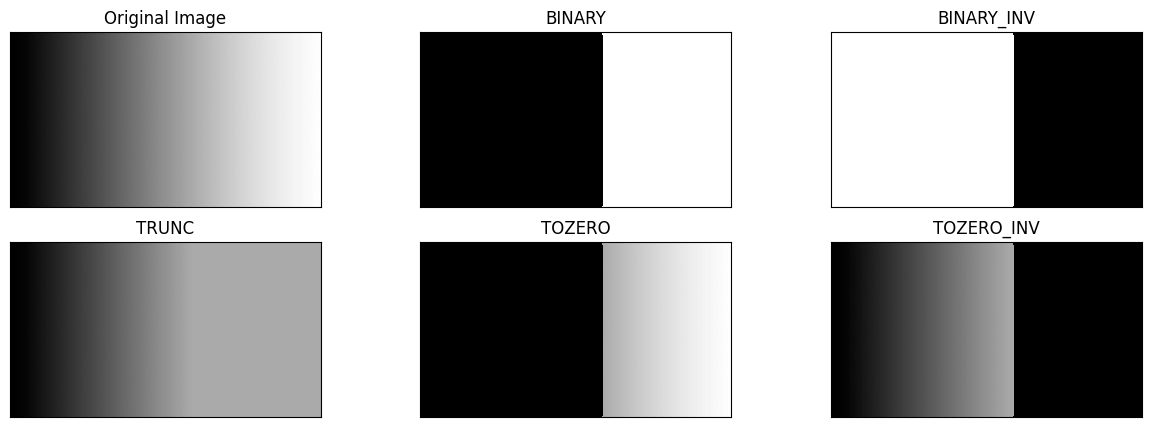

In [37]:
filename = ('/content/drive/MyDrive/pcvk/image_thres/gradient.jpg')

img = cv.imread(filename)
img_array = np.array(img)

thresh = 170

# binary
binary = np.where(img > thresh, 255, 0).astype(np.uint8)

# binary_inv
binary_inv = np.where(img > thresh, 0, 255).astype(np.uint8)

# trunc
trunc = img.astype(np.uint8)
trunc[img > thresh] = thresh

# tozero
tozero = np.where(img > thresh, img, 0).astype(np.uint8)

# tozero_inv
tozero_inv = np.where(img > thresh, 0, img).astype(np.uint8)

titles = ['Original Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, binary, binary_inv, trunc, tozero, tozero_inv]

plt.figure(figsize = (15, 5))

for i in range(len(images)):
    plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray', interpolation='nearest')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

In [38]:
# @title Fungsi untuk melakukan Otsu's Thresholding manual
def otsu_thresholding(image):
    # Histogram dan total pixel
    hist, bins = np.histogram(image.ravel(), 256, [0, 256])
    total_pixels = image.size

    current_max, threshold = 0, 0                   # menyimpan nilai maksimum variansi antar kelas dan threshold
    sum_total, sum_foreground = 0, 0                # Menyimpan jumlah total intensitas dan intensitas foreground
    weight_background, weight_foreground = 0, 0     # Menyimpan jumlah kumulatif piksel untuk background dan foreground

    # Perhitungan sum total dari histogram
    for i in range(256):
        sum_total += i * hist[i]

    # Iterasi untuk mencari threshold optimal berdasarkan metode Otsu
    for t in range(256):
        weight_background += hist[t]
        if weight_background == 0:
            continue
        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        sum_foreground += t * hist[t]

        mean_background = sum_foreground / weight_background
        mean_foreground = (sum_total - sum_foreground) / weight_foreground

        # Menghitung variansi antar kelas
        var_between = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2

        # Memperbarui threshold jika variansi antar kelas lebih besar dari nilai sebelumnya
        if var_between > current_max:
            current_max = var_between
            threshold = t

    # Menggunakan threshold yang ditemukan
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)

    return binary_image, threshold

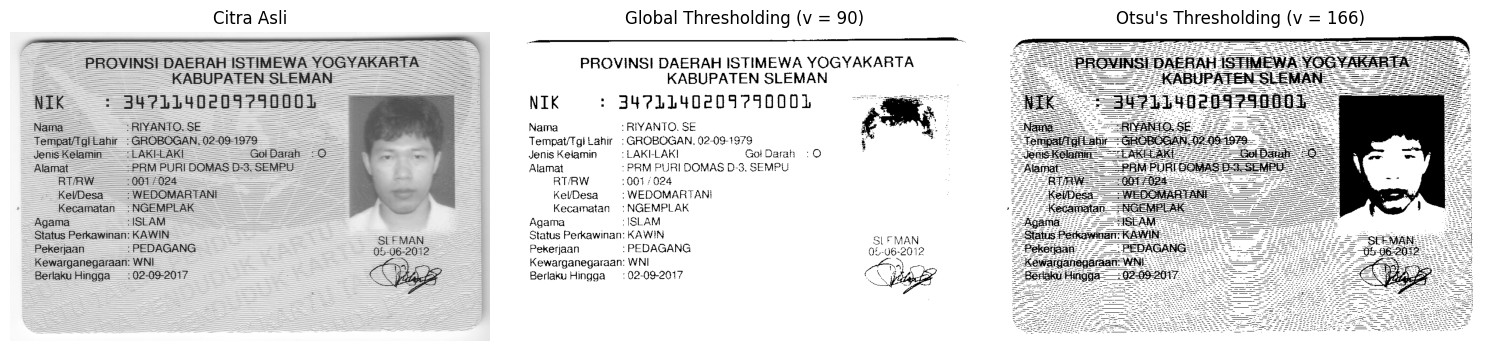

In [39]:
img = cv.imread('/content/drive/MyDrive/pcvk/KTP-Riyanto.jpg', cv.IMREAD_GRAYSCALE)

# Global Thresholding dengan nilai threshold 90
global_threshold = 90
global_thresh_img = np.where(img > global_threshold, 255, 0).astype(np.uint8)

# Otsu's Thresholding
otsu_thresh_img, otsu_threshold = otsu_thresholding(img)

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Citra Asli')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(global_thresh_img, cmap='gray')
plt.title(f'Global Thresholding (v = {global_threshold})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(otsu_thresh_img, cmap='gray')
plt.title(f"Otsu's Thresholding (v = {otsu_threshold})")
plt.axis('off')

plt.tight_layout()
plt.show()


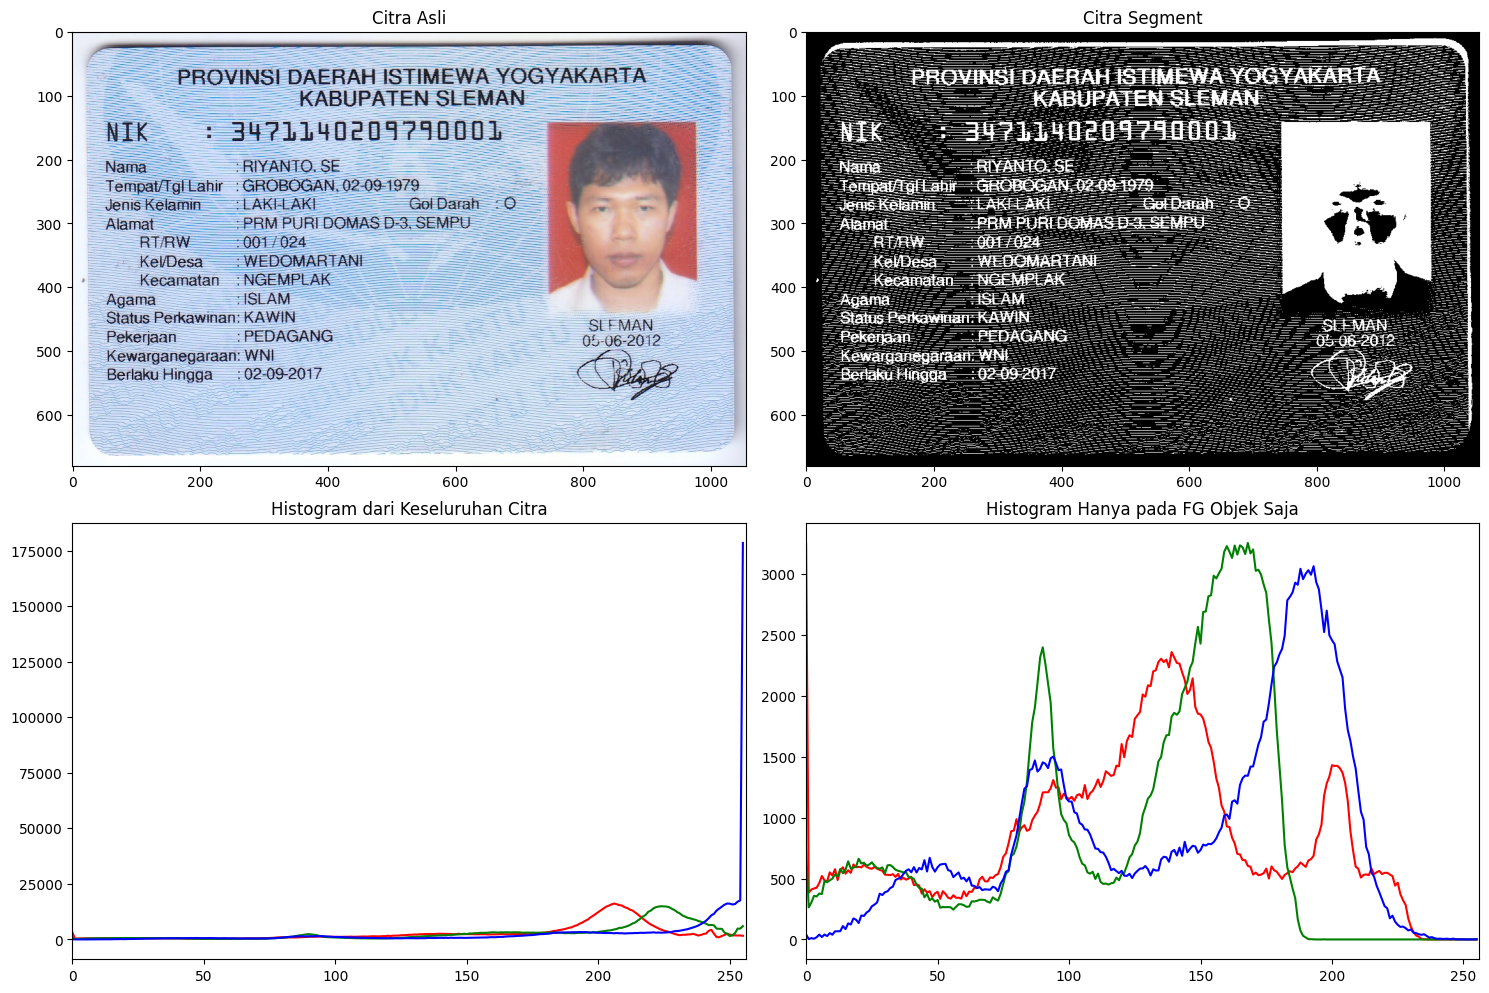

In [40]:
# @title Buat histogram dari citra tersegmentasi

img = cv.imread('/content/drive/MyDrive/pcvk/KTP-Riyanto.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Ubah gambar ke grayscale dan buat mask untuk segmentasi
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(gray, 185, 255, cv.THRESH_BINARY_INV)

# Hitung histogram untuk keseluruhan citra
hist_r = cv.calcHist([img], [0], None, [256], [0, 256])  # Histogram merah
hist_g = cv.calcHist([img], [1], None, [256], [0, 256])  # Histogram hijau
hist_b = cv.calcHist([img], [2], None, [256], [0, 256])  # Histogram biru

# Hitung histogram hanya untuk bagian foreground
hist_fg_r = cv.calcHist([img], [0], mask, [256], [0, 256])  # Histogram merah untuk foreground
hist_fg_g = cv.calcHist([img], [1], mask, [256], [0, 256])  # Histogram hijau untuk foreground
hist_fg_b = cv.calcHist([img], [2], mask, [256], [0, 256])  # Histogram biru untuk foreground

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Citra Asli')

plt.subplot(2, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Citra Segment')

plt.subplot(2, 2, 3)
plt.plot(hist_r, color='red')
plt.plot(hist_g, color='green')
plt.plot(hist_b, color='blue')
plt.title('Histogram dari Keseluruhan Citra')
plt.xlim([0, 256])

plt.subplot(2, 2, 4)
plt.plot(hist_fg_r, color='red')
plt.plot(hist_fg_g, color='green')
plt.plot(hist_fg_b, color='blue')
plt.title('Histogram Hanya pada FG Objek Saja')
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

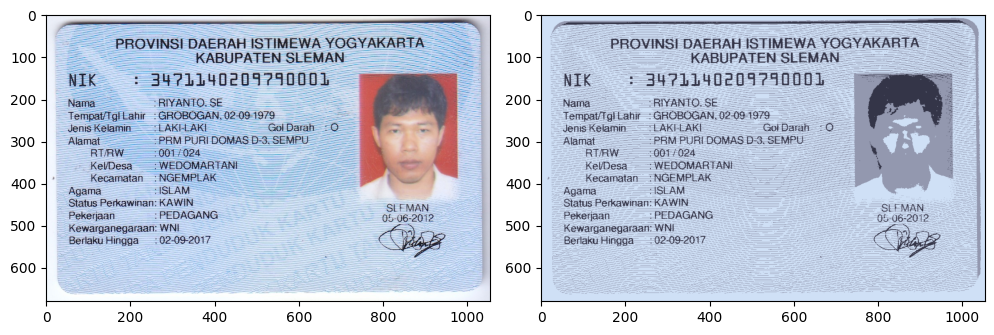

In [41]:
image = cv.imread('/content/drive/MyDrive/pcvk/KTP-Riyanto.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Ubah citra ke bentuk 2D
pixel_values = image.reshape((-1, 3))  # Mengubah citra menjadi 2D
pixel_values = np.float32(pixel_values)  # Mengubah tipe data menjadi float32

# K-Means clustering
k = 3  # Jumlah kluster
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# Mengubah tipe data kembali ke uint8
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# Tampilkan hasil
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(segmented_image)

plt.tight_layout()
plt.show()

em

PROVINSI DAERAH ISTIMEWA YOGYAKARTA
KABUPATEN SLEMAN

 

NIK : 34711140209790001

Nama :RIYANTO. SE

Tempat/Tgl Lahir : GROBOGAN. 02-09-1979

Jenis Kelamin : LAKI-LAKI Gol Darah : 0

Alamat PRM PURI DOMAS D-3. SEMPU
RTRW 1001 1024

Kel/Desa : WEDOMARTANI!
Kecamatan : NGEMPLAK

Agama "ISLAM
Status Bean KAWIN SLEMAN
Pekerjaan : PEDAGANG 05-06-2012

Kewarganegaraan: WNI HI —
Berlaku Hingga :02-09-2017 NIA

   
 

 



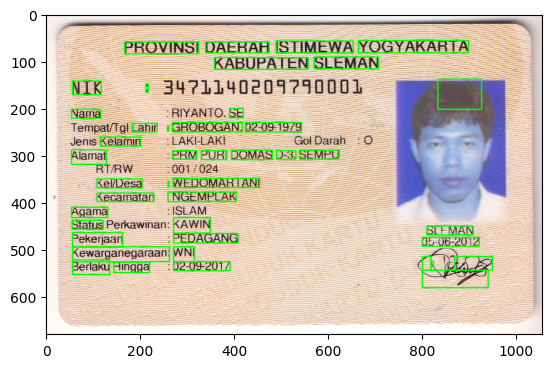

In [42]:
# Load the image
img = cv.imread('/content/drive/MyDrive/pcvk/KTP-Riyanto.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Thresholding
th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_TRUNC)

# Detecting text
result = pytesseract.image_to_string(threshed, lang="ind")

# Getting bounding boxes for detected text
boxes = pytesseract.image_to_data(threshed, output_type=pytesseract.Output.DICT)

# Draw rectangles around detected text
for i in range(len(boxes['text'])):
    if int(boxes['conf'][i]) > 60:  # Only consider boxes with a confidence level > 60
        (x, y, w, h) = (boxes['left'][i], boxes['top'][i], boxes['width'][i], boxes['height'][i])
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Normalize and print result
for word in result.split("\n"):
    if "”—" in word:
        word = word.replace("”—", ":")

    # Normalize NIK
    if "NIK" in word:
        nik_char = word.split()
        if "D" in word:
            word = word.replace("D", "0")
        if "?" in word:
            word = word.replace("?", "7")

    print(word)

plt.imshow(img)
plt.show()